# Fasty Drone Obstacle Course Navigation

This cell imports all necessary modules required for the simulation, control design, and symbolic modeling of the spacecraft system.

In [33]:
# Import standard Python libraries
import numpy as np                  # For numerical operations
import matplotlib.pyplot as plt     # For plotting
import secrets                      # For generating random numbers
import ae353_drone                  # For drone simulation
from control import lqr             # For Linear Quadratic Regulator (LQR) control

# Configure NumPy to suppress scientific notation for small values
np.set_printoptions(suppress=True)

## Create dynamic model

In the following cell, we derive the equations of motion for the drone's dynamics.

In [34]:
import sympy as sym
import numpy as np
from control import lqr

params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

# Define the symbols for the state variables and parameters
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# Define the symbols for the roll, pitch, and yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define the symbols for the velocity components in the body frame
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# Define the symbols for the angular velocity components in the body frame
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# Define the symbols for the torques applied to the drone
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# Define the symbol for the force applied in the z-direction
f_z = sym.symbols('f_z')

# Define the symbols for the parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# Define the rotation matrices for the drone's orientation
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])    # Unit vector in x-direction
ey = sym.Matrix([[0], [1], [0]])    # Unit vector in y-direction
ez = sym.Matrix([[0], [0], [1]])    # Unit vector in z-direction

# Calculate the matrix that relates the angular velocity to the angular rates
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define the force vector in the body frame
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# Define the torque vector in the body frame
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# Define the equations of motion for the drone
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

# Define the position of the drone in the world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Define the position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Define position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Define the sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

# Define the state vector, input vector, and output vector
m = sym.Matrix([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
n = sym.Matrix([tau_x, tau_y, tau_z, f_z])
o = sym.Matrix([p_x, p_y, p_z, psi, theta, phi])

# Define the equilibrium point for the system
sub = {
    p_x: 0.0,
    p_y: 0.0,
    p_z: 0.0,
    psi: 0.0,
    theta: 0.0,
    phi: 0.0,
    v_x: 0.0,
    v_y: 0.0,
    v_z: 0.0,
    w_x: 0.0,
    w_y: 0.0,
    w_z: 0.0,
    tau_x: 0.0,
    tau_y: 0.0,
    tau_z: 0.0,
    f_z: 981./100./2.,
}

# Substitute the equilibrium point into state, input, and output vectors
m_e = np.array(m.subs(sub)).astype(np.float64)
n_e = np.array(n.subs(sub)).astype(np.float64)
o_e = np.array(o.subs(sub)).astype(np.float64)

# Compute the Jacobian matrix with respect to the state vector 'm' at equilibrium values to get matrix A
A = f.jacobian(m).subs(sub)

# Compute the Jacobian matrix with respect to the input vector 'n' at equilibrium values to get matrix B
B = f.jacobian(n).subs(sub)

# Compute the Jacobian matrix with respect to the output vector 'o' at equilibrium values to get matrix C
C = g.jacobian(m).subs(sub)

# Convert the matrices to NumPy arrays and ensure they are of type float64 and type compabible with LQR
A = np.array(A).astype(np.float64)
B = np.array(B).astype(np.float64)
C = np.array(C).astype(np.float64)

## Create Controller and Observer Gain Matrices

In the following code block, we design observer and controller gain matrices. Multiple gain matrices for the controller are defined for the purpose of gain scheduling throughout the obstacle course to adapt for different situations.

In [52]:
# Define the Q matrices for different scenarios

# Q matrix for entering the first ring
Q_start = np.diag([0.15, 0.15, 7.5, 1, 1, 1,
                        1, 1, 1, 1, 1, 1])

# Q matrix for zigzagging through central rings, default gain matrix if no other is specified
Q_zigzag = np.diag([0.09, 0.09, 10, 1, 1, 1,
                    1, 1, 1, 1, 1, 1])

# Q matrix for fast flight in the y-direction
Q_fasty = np.diag([0.1, 0.15, 10, 1, 1, 1,
                    1, 1, 1, 1, 1, 1])

# Q matrix for flying through the rings in the x-direction
Q_ringx = np.diag([0.13, 0.15, 9.5, 1, 1, 1,
                    1, 1, 1, 1, 1, 1])

# Q matrix for flying through the rings in the y-direction
Q_ringy = np.diag([0.08, 0.1, 7, 1, 1, 1,
                    1, 1, 1, 1, 1, 1])

# Q matrix for entering ring 13
Q_13 = np.diag([0.1, 0.1, 13, 1, 1, 1,
                    1, 1, 1, 1, 1, 1])

# Define the R matrix for the control inputs
Rc = np.diag([1, 1, 1, 1]) * 1e2 * 0.9

# Compute the LQR gains for each scenario described above for each Q matrix
K_start, _, _ = lqr(A, B, Q_start, Rc)
K_zigzag, _, _ = lqr(A, B, Q_zigzag, Rc)
K_fasty, _, _ = lqr(A, B, Q_fasty, Rc)
K_ringx, _, _ = lqr(A, B, Q_ringx, Rc)
K_ringy, _, _ = lqr(A, B, Q_ringy, Rc)
K_13, _, _ = lqr(A, B, Q_13, Rc)

# Define the Q matrix for the observer
Qo = np.diag([1, 1, 1, 1, 1, 1]) * 1e2

# Define the R matrix for the observer
Ro = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) * 1e2

# Compute the LQR gains for the observer
L, _, _ = lqr(A.T, C.T, np.linalg.inv(Ro), np.linalg.inv(Qo))
L = L.T

K_start

array([[-0.        , -0.04082483,  0.        , -0.        , -0.        ,
         0.54359519, -0.        , -0.12504204, -0.        ,  0.11666897,
         0.        , -0.        ],
       [ 0.04082483, -0.        , -0.        , -0.        ,  0.54359519,
         0.        ,  0.12504204, -0.        , -0.        ,  0.        ,
         0.11666897,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.10540926,  0.        ,
        -0.        ,  0.        ,  0.        , -0.        , -0.        ,
         0.        ,  0.10933611],
       [ 0.        , -0.        ,  0.28867513, -0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.54752739, -0.        ,
        -0.        , -0.        ]])

## Control Design

In the following cell, we define a controller that maps sensor measurements to actuator commands, using state feedback and an observer to estimate the drone's state. The run function has a sample rate of 25 Hz.

In [36]:
class Controller:
    def __init__(self):
        self.dt = 0.04          # Time step for simulation, reflects the sample rate of 25 Hz
        self.slope = None       # Slope of the line connecting the current ring and checkpoint
        self.zigzag = None      # Zigzag vector for the drone
        self.ring_radius = 1.0  # Radius of the ring
        self.count = 0         # Counter helper variable to ensure tracked waypoints are only updated once
        self.variables_to_log = ['error', 'xhat', 'current_waypoint'] # Variables to log for plotting and analysis

    def get_color(self):
        return [
            0., # Red value
            1., # Green value
            0., # Blue value
        ]

    def reset(
            self,
            p_x, p_y, p_z, # The approximate initial position of the drone (meters)
            yaw,           # The approximate initial yaw angle of drone (radians)
        ):
        self.p_x = p_x     # Saves the initial x position of the drone
        self.p_y = p_y     # Saves the initial y position of the drone
        self.p_z = p_z     # Saves the initial z position of the drone
        self.yaw = yaw     # Saves the initial yaw angle of the drone
        
        # Reset the state estimate
        self.xhat = np.array([p_x, p_y, p_z, yaw, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        self.passed_rings = []          # List to track the rings that have been passed
        self.next_ring = []             # List to track the next ring to be passed
        self.passed_checkpoints = []    # List to track the checkpoints that have been passed
        self.next_checkpoints = []      # List to track the next checkpoints to be passed
        self.prev_waypoint = np.array([self.p_x, self.p_y, self.p_z])  # Previous waypoint tracked, used to calculate error between actual position and desired position
        self.current_waypoint = None    # Current waypoint tracked, used to calculate error between actual position and desired position
        self.error = 0                  # Error variable to track the difference between the desired and actual position along a desired path trajectory
    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,
            pos_others,
        ):

        # Define helper function to determine if the drone reached a destination
        def reached_destination(xhat, goal):
            return np.linalg.norm(xhat - goal) < 0.75
        
        # Define helper function to get the next checkpoint in the central zigzag rings portion
        def get_next_checkpoint(ring_pos, current_checkpoint_pos, ring_radius, forward):
            # Calculate the slope of the line connecting the current ring and checkpoint
            slope = 0.9 * (current_checkpoint_pos[1] - ring_pos[1]) / (current_checkpoint_pos[0] - ring_pos[0])
            # Calculate the x and y coordinates of the next checkpoint
            if (forward):
                x_next = ring_pos[0] + self.ring_radius
                y_next = ring_pos[1] + slope * ring_radius
            else:
                x_next = ring_pos[0] - self.ring_radius
                y_next = ring_pos[1] - slope * ring_radius
            return np.array([x_next, y_next, ring_pos[2]])
        
        # Define helper function to get the direction vector from the drone's initial position to the goal
        def get_drone_dir(initial_pos, goal):
            dir = np.array([goal[0] - initial_pos[0], goal[1] - initial_pos[1], goal[2] - initial_pos[2]])
            return dir / np.linalg.norm(dir)
        
        # Define helper function to determine if the drone is turning in a specific direction
        def turning(direction):
            threshold = 0.1
            if direction == "x":
                return abs(self.xhat[6]) < threshold
            elif direction == "y":
                return abs(self.xhat[7]) < threshold
            elif direction == "z":
                return abs(self.xhat[8]) < threshold
            else:
                raise ValueError("Invalid direction. Choose 'x', 'y', or 'z'.")
        
        # Define boolean variable to track if the waypoint has been updated
        waypoint_updated = False

        # Define the default desired state as the position of the ring
        x_des = np.array([*pos_ring, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        
        # Keeps track of the next ring to be passed and all passed rings
        if (len(self.next_ring) == 0 or not np.allclose(pos_ring, self.next_ring[-1], atol=1e-3)): # runs everytime pos_ring changes
            self.next_ring.append(pos_ring.copy())
            if (len(self.next_ring) > 1):
                self.passed_rings.append(self.next_ring[-2].copy())
        
        # Track the rings, save each ring location to self.passed_rings
        dist_to_ring = np.linalg.norm(self.xhat[:3] - pos_ring)
        
        # If before ring 8, drone is moving forward, if after ring 8, drone is moving backward
        forward = True
        if (len(self.passed_rings) >= 8):
            forward = False

        # Ensure drone rises above initial blue ring quickly
        if (self.xhat[2] < 2.0 and len(self.passed_checkpoints) == 0):
            checkpoint = np.array([self.p_x, self.p_y, 1.075])
            x_des[:3] = checkpoint + np.array([0, 0, 15.0]) # Overshoot here
            self.current_waypoint = checkpoint
            if reached_destination(self.xhat[:3], checkpoint):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(self.xhat[:3].copy())
                self.next_checkpoints.append(self.xhat[:3].copy())
        
        # Approaching ring 1
        if (len(self.passed_rings) == 0 and len(self.passed_checkpoints) == 1):
            x_des[:3] = self.next_ring[-1] + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 4.5 # Overshoot here
            self.current_waypoint = self.next_ring[-1]
            if ((self.xhat[1] - self.next_ring[-1][1])**2 + (self.xhat[2] - self.next_ring[-1][2])**2 < (self.ring_radius - 0.1)**2):
                x_des[:3] = self.next_ring[-1] + np.array([2.0, 0, 0])

        # Approaching ring 2, setting a checkpoint when the drone begins to turn for an accurate slope calculation to the next ring
        if (len(self.passed_rings) == 1 and turning("y") and len(self.passed_checkpoints) == 1):
            if any(self.prev_waypoint != self.current_waypoint):    
                self.prev_waypoint = self.current_waypoint
            self.passed_checkpoints.append(self.xhat[:3].copy())
            self.next_checkpoints.append(self.xhat[:3].copy())

        # Approaching ring 2
        if (len(self.passed_rings) == 1 and len(self.passed_checkpoints) == 2):
            del_z = self.next_ring[-1][2] - self.passed_checkpoints[-1][2]
            x_des[:3] = pos_ring + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 2.5 # Overshoot here, max 2.0
            self.current_waypoint = pos_ring
            # Experimentally obtained values to adjust the desired z position of the drone
            if (del_z < -0.5):
                x_des[2] += 1.0
            elif (del_z > 1.0):
                x_des[2] -= 0.5
            if ((self.xhat[0] - self.next_ring[-1][0])**2 + (self.xhat[2] - self.next_ring[-1][2])**2 < (self.ring_radius - 0.15)**2) and abs(self.xhat[1] - self.next_ring[-1][1]) > 1.25:
                x_des[:3] += dir_ring * 2.0

        # To get to first checkpoint after first zigzag ring, entering zigzag rings
        if len(self.passed_rings) == 2 and len(self.passed_checkpoints) == 2:
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 0:
                self.count += 1
                self.prev_waypoint = self.current_waypoint
            self.slope = 0.5 * (self.passed_rings[-1][1] - self.passed_rings[-2][1]) / (self.passed_rings[-1][0] - self.passed_rings[-2][0])
            self.zigzag = np.array([self.ring_radius, self.slope * self.ring_radius, 0])
            checkpoint = self.passed_rings[-1][:3] + self.zigzag
            x_des[:3] = checkpoint + np.array([0, 0, 0.75]) + get_drone_dir(self.passed_rings[-1], checkpoint) * 4.0 # Overshoot here
            self.current_waypoint = checkpoint
            if reached_destination(self.xhat[:3], checkpoint):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(checkpoint.copy())
                self.next_checkpoints.append(checkpoint.copy())
                next_checkpoint = get_next_checkpoint(pos_ring, checkpoint, self.ring_radius, forward)
                self.next_checkpoints.append(next_checkpoint.copy())
                self.current_waypoint = self.next_checkpoints[-1]

        # Approaching ring 3
        if (len(self.passed_checkpoints) == 3):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + (get_drone_dir(self.passed_checkpoints[-1], pos_ring)) * 4.0 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
                self.current_waypoint = self.next_checkpoints[-1]

        # Approaching ring 4
        if (len(self.passed_checkpoints) == 4):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 3.5 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
                self.current_waypoint = self.next_checkpoints[-1]

        # Approaching ring 5
        if (len(self.passed_checkpoints) == 5):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 3.5 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
                self.current_waypoint = self.next_checkpoints[-1]
                waypoint_updated = True

        # Approaching ring 6
        if (len(self.passed_rings) == 5 and len(self.passed_checkpoints) == 6):
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 1 and not waypoint_updated:    
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            x_des[:3] = pos_ring + np.array([0, 0, 0.5]) + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 2.5 # Overshoot here
            if not waypoint_updated:
                self.current_waypoint = pos_ring

        # Approaching ring 7
        if (len(self.passed_rings) == 6 and len(self.passed_checkpoints) == 6
            ):
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 2: 
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            x_des[:3] = pos_ring + get_drone_dir(self.passed_rings[-1], pos_ring) * 3.0 # Overshoot here
            self.current_waypoint = pos_ring
            if ((self.xhat[1] - pos_ring[1])**2 + (self.xhat[2] - pos_ring[2])**2 < (self.ring_radius - 0.)**2):
                x_des[:3] = pos_ring + dir_ring * 2.0 # Overshoot here

        # Approaching checkpoint placed near ring 7
        if (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 6):
            if all(self.prev_waypoint != self.current_waypoint):
                self.prev_waypoint = self.current_waypoint
            checkpoint = np.array([self.passed_rings[-1][0] + 0.6, self.passed_rings[-1][1], self.passed_rings[-1][2]])
            x_des[:3] = checkpoint + np.array([4.5, 0, 0]) # Overshoot here
            self.current_waypoint = checkpoint
            if (reached_destination(self.xhat[:3], checkpoint)):
                self.passed_checkpoints.append(checkpoint.copy())

        # Approaching checkpoint placed near ring 8
        if (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 7):
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 3:
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            checkpoint = np.array([pos_ring[0] + 0.50, pos_ring[1], pos_ring[2]])
            x_des[:3] = checkpoint + np.array([0, 1.5, 0])
            self.current_waypoint = checkpoint
            if ((self.xhat[1] - self.next_ring[-1][1])**2 + (self.xhat[2] - self.next_ring[-1][2])**2 < (self.ring_radius - 0.15)**2):
                self.passed_checkpoints.append(checkpoint.copy())
                x_des[:3] = pos_ring + dir_ring * 4.0 # Overshoot here
        
        # Approaching ring 8
        if (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 8):
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 4:
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            x_des[:3] = pos_ring + dir_ring * 4.0 # Overshoot here
            self.current_waypoint = pos_ring

        # Approaching ring 9
        if (len(self.passed_rings) == 8 and len(self.passed_checkpoints) == 8):
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 5:
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            x_des[:3] = self.next_ring[-1] + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 4.5 # Overshoot here
            self.current_waypoint = self.next_ring[-1]

        # Approaching ring 9, setting a checkpoint when the drone begins to turn for an accurate slope calculation to the next ring
        if (len(self.passed_rings) == 8 and turning("y") and len(self.passed_checkpoints) == 8):
            self.passed_checkpoints.append(self.xhat[:3].copy())
            self.next_checkpoints.append(self.xhat[:3].copy())

        # Approaching ring 9
        if (len(self.passed_rings) == 8 and len(self.passed_checkpoints) == 9):
            del_z = self.next_ring[-1][2] - self.passed_checkpoints[-1][2]
            x_des[:3] = self.next_ring[-1] + get_drone_dir(self.passed_checkpoints[-1], self.next_ring[-1]) * 2.0 # Overshoot here
            if (del_z < 0.0):
                x_des[2] += 0.75
            elif (del_z > 1.0):
                x_des[2] -= 0.25
            if ((self.xhat[0] - self.next_ring[-1][0])**2 + (self.xhat[2] - self.next_ring[-1][2])**2 < (self.ring_radius - 0.15)**2) and abs(self.xhat[1] - self.next_ring[-1][1]) > 1.25:
                x_des[:3] += dir_ring * 2.0 # Overshoot here

        # Approaching ring 10
        if len(self.passed_rings) == 9 and len(self.passed_checkpoints) == 9:
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 6:
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            self.slope = 0.60 * (self.passed_rings[-1][1] - self.passed_rings[-2][1]) / (self.passed_rings[-1][0] - self.passed_rings[-2][0])
            self.zigzag = np.array([self.ring_radius, self.slope * self.ring_radius, 0])
            checkpoint = self.passed_rings[-1] - self.zigzag
            x_des[:3] = checkpoint + np.array([0, 0, 0.5]) + get_drone_dir(self.passed_rings[-1], checkpoint) * 4.0 # Overshoot here
            self.current_waypoint = checkpoint
            if reached_destination(self.xhat[:3], checkpoint):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(checkpoint.copy())
                self.next_checkpoints.append(checkpoint.copy())
                next_checkpoint = get_next_checkpoint(pos_ring, checkpoint, self.ring_radius, forward)
                self.next_checkpoints.append(next_checkpoint.copy())
                self.current_waypoint = self.next_checkpoints[-1]

        # Passing through ring 11
        if (len(self.passed_checkpoints) == 10):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + (get_drone_dir(self.passed_checkpoints[-1], pos_ring)) * 4.0 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
                self.current_waypoint = self.next_checkpoints[-1]

        # Passing through ring 12
        if (len(self.passed_checkpoints) == 11):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + (get_drone_dir(self.passed_checkpoints[-1], pos_ring)) * 3.5 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
                self.current_waypoint = self.next_checkpoints[-1]

        # Passing through ring 13
        if (len(self.passed_checkpoints) == 12):
            x_des[:3] = self.next_checkpoints[-1] + np.array([0, 0, 0.5]) + (get_drone_dir(self.passed_checkpoints[-1], pos_ring)) * 3.5 # Overshoot here
            if reached_destination(self.xhat[:3], self.next_checkpoints[-1]):
                self.prev_waypoint = self.current_waypoint
                self.passed_checkpoints.append(self.next_checkpoints[-1].copy())
                self.next_checkpoints.append(get_next_checkpoint(pos_ring, self.next_checkpoints[-1], self.ring_radius, forward))
                self.current_waypoint = self.next_checkpoints[-1]

        # Approaching ring 13
        if (len(self.passed_rings) == 12 and len(self.passed_checkpoints) == 13):
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 7 and not waypoint_updated:
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            x_des[:3] = pos_ring + get_drone_dir(self.passed_checkpoints[-1], pos_ring) * 4.0 # Overshoot here
            if not waypoint_updated:
                self.current_waypoint = pos_ring
       
        # Approaching ring 14, setting a checkpoint when the drone begins to turn for an accurate slope calculation to the next ring
        if (len(self.passed_rings) == 13 and len(self.passed_checkpoints) == 13):
            self.prev_waypoint = self.current_waypoint
            self.passed_checkpoints.append(self.xhat[:3].copy())
            self.current_waypoint = self.passed_checkpoints[-1]

        # Approaching ring 14
        if (len(self.passed_rings) == 13 and len(self.passed_checkpoints) == 14):
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 8:
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            x_des[:3] = self.next_ring[-1] + np.array([0, -0.5, 0]) + get_drone_dir(self.passed_checkpoints[-1], self.next_ring[-1]) * 2.5 # Overshoot here
            self.current_waypoint = self.next_ring[-1]
            if ((self.next_ring[-1][0] - self.xhat[0])**2 + (self.next_ring[-1][1] - self.xhat[1])**2 < (self.ring_radius - 0.4)**2):
                x_des[:3] = self.next_ring[-1] + dir_ring * 5.0 # Boost its motion forward through the ring
        
        # Approaching last ring
        if (is_last_ring):
            if any(self.prev_waypoint != self.current_waypoint) and self.count == 9:
                self.prev_waypoint = self.current_waypoint
                self.count += 1
            # Move the drone towards the center of the last ring, but when it hovers anywhere above the final ring, it will immediately drop downwards
            if (len(self.passed_checkpoints) == 14):
                R = 2.5
                checkpoint = np.array([0, 0, 1.75])
                x_des[:3] = checkpoint + get_drone_dir(self.passed_rings[-1], checkpoint) * 5.0 # Overshoot here
                self.current_waypoint = checkpoint
                if (self.xhat[0] < R*np.sqrt(2)/2 and self.xhat[1] > -R*np.sqrt(2)/2):
                    self.prev_waypoint = self.current_waypoint
                    self.passed_checkpoints.append(checkpoint.copy())
                    self.current_waypoint = np.array([0, 0, 0])
            else:
                self.current_waypoint = np.array([self.xhat[0], self.xhat[1], 0])
                x_des[:3] = np.array([0, 0, -50])
        
        # Extra boost to the drone's motion when it is close to the ring
        if dist_to_ring < 1.0:
            x_des[:3] += dir_ring * 3.0

        # Scheduled gain matrices based on the scenario, compute the control input u using state feedback
        if (dist_to_ring < 1.0 and abs(dir_ring[0]) == 1):
            u = -K_ringx @ (self.xhat - x_des)
        elif (dist_to_ring < 1.0 and abs(dir_ring[1]) == 1):
            u = -K_ringy @ (self.xhat - x_des)
        elif (len(self.passed_rings) < 1): # approaching first ring or approaching last ring
            u = -K_start @ (self.xhat - x_des)
        elif (len(self.passed_rings) == 7 and len(self.passed_checkpoints) == 7):
            u = -K_fasty @ (self.xhat - x_des)
        elif (len(self.passed_rings) == 13):
            u = -K_13 @ (self.xhat - x_des)
        else:
            u = -K_zigzag @ (self.xhat - x_des)

        # Calculation of the error between the drone's position and the desired position by finding the orthgonal distance between the drone and the desired path established by the waypoints
        PM = self.xhat[:3] - self.prev_waypoint
        v = self.current_waypoint - self.prev_waypoint
        self.error = np.linalg.norm(np.cross(PM, v)) / np.linalg.norm(v)

        # Set the torque and force commands based on the control input
        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        f_z = u[3] + n_e[3][0]
        y = np.array(pos_markers)

        # Update the state estimate using the observer
        x_hatdot = A @ self.xhat + B @ u - L @ (C @ self.xhat - y)
        self.xhat += + x_hatdot.flatten() * self.dt

        return tau_x, tau_y, tau_z, f_z
    


## Define Iterate Function for Repetition Testing

In the cell below, we define a function called 'iterate()' with parameter 'seed'. It will be called in a for-loop 100 times for 100 trials, iterating through each 'seed' in 'seeds' indexed from 0 to 99. 'seeds', the list of 100 unique seeds, is defined in block following the one below.

In [37]:
def iterate(seed):
    simulator = ae353_drone.Simulator(seed=seed)
    simulator.display_meshcat = False
    simulator.set_rules(
        error_on_print=True,    # <-- allow print statements in controller code
        error_on_timeout=True,  # <-- allow long runtimes in controller code
        error_on_inactive=True, # <-- allow inactivity
    )
    simulator.clear_drones()

    simulator.add_drone(Controller, 'sub50', 'dssong2.png')
    simulator.reset()
    simulator.run(
        max_time=None,       # <-- if None, then simulation will run until all drones fail or finish
        print_debug=False,  # <-- if False, then nothing will be printed (good for data collection)
    )

    (
        did_it_fail,
        did_it_finish,
        what_time_did_it_finish,
    ) = simulator.get_result('sub50')
    data = simulator.get_data('sub50')
    return did_it_fail, did_it_finish, what_time_did_it_finish, data

Shown in the following cell is the list of 100 seeds used to reproduce the same results.

In [38]:
seeds = [4199111895,
 4138453920,
 1212721304,
 422740383,
 1440762015,
 4214078573,
 4076783659,
 358675817,
 1094852723,
 1122598259,
 2909491035,
 3365385200,
 3106479880,
 40853821,
 4221529092,
 1496258762,
 1761899329,
 55013709,
 1165153986,
 3111895665,
 974136006,
 3402473223,
 823257609,
 255909606,
 1916152804,
 3423919605,
 2683163480,
 589289067,
 3672606428,
 1707927347,
 2770421213,
 45122972,
 3640564681,
 2861991593,
 3927723272,
 4050266999,
 551946892,
 292640226,
 2586347681,
 1577479023,
 1612888507,
 1763858779,
 1286457880,
 2472807670,
 1072829324,
 3041996129,
 3553741233,
 3127973048,
 1321928064,
 2791469381,
 2825810551,
 1685636403,
 3395830138,
 1437511058,
 3429222649,
 1612093693,
 2067539541,
 1368548830,
 734090132,
 1661973736,
 44791199,
 2776329567,
 3289989443,
 933874101,
 3819289778,
 1817512846,
 2893199238,
 3638259220,
 2404164053,
 1942549049,
 1290203602,
 3791526685,
 288963979,
 2377384764,
 1378030921,
 2623909265,
 2400568257,
 1828522078,
 3377956359,
 2408841286,
 1258740464,
 2285611169,
 4136547553,
 1946206473,
 763568250,
 2236581839,
 2405440041,
 2456467398,
 3011975529,
 2520989229,
 4059352207,
 795823598,
 3149483636,
 3743097084,
 2100938460,
 34333968,
 2386723513,
 1711684079,
 3600743288,
 1629130252]

In the following cell, we collect the data from the 100 trials ran and to help calculate the success and failure rate. We are unable to avoid printing out argv[0] upon each trial ran, we call no print statements unless our drone did not complete the obstacle course.

In [39]:
fails = 0
finishes = 0
datas = []
for i in range(100):
    did_it_fail, did_it_finish, what_time_did_it_finish, data = iterate(seeds[i])
    if did_it_fail:
        fails += 1
    elif did_it_finish:
        finishes += 1
    else:
        print("The drone did not finish (yet).")
    datas.append(data)

argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=


In [51]:
wp = datas[0]['current_waypoint']
# Convert each waypoint to a tuple (since arrays/lists are unhashable)
unique_waypoints = set(tuple(w) for w in wp)
# If you want them back as arrays:
unique_waypoints = [np.array(w) for w in unique_waypoints]
print(unique_waypoints)

[array([ 0.90763229, -1.36070661,  0.        ]), array([ 0.63220851, -0.85506527,  0.        ]), array([13.4       ,  0.52162713,  5.        ]), array([13.5       , -1.14285714,  5.        ]), array([17.1,  4. ,  3. ]), array([0.  , 0.  , 1.75]), array([11.3       , -0.63754427,  5.        ]), array([11.4       ,  0.93506494,  5.        ]), array([ 0.73820595, -1.05109357,  0.        ]), array([ 0.79333367, -1.15110126,  0.        ]), array([ 1.03106933, -1.57609699,  0.        ]), array([ 9.3       , -0.76505313,  5.        ]), array([16.6,  4. ,  3. ]), array([ 7.1       , -0.95238095,  5.        ]), array([ 0.9694746 , -1.47073622,  0.        ]), array([7.2       , 0.62595256, 5.        ]), array([0., 0., 0.]), array([ 0.68237843, -0.95241166,  0.        ]), array([-1.15111397,  0.86648458,  1.075     ]), array([6.1, 0. , 5. ]), array([14.5,  0. ,  5. ]), array([15.5       , -0.42678584,  5.        ]), array([ 4., -4.,  6.]), array([9.2       , 0.77922078, 5.        ]), array([ 0.84

In the following cell, we calculate the success and failure rate over 100 trials.

In [40]:
print("Fails: ", fails/100)
print("Finishes: ", finishes/100)

Fails:  0.01
Finishes:  0.99


## Plotting and Data Analysis

In the first plot, we create a histogram of the error between actual position and desired position. 

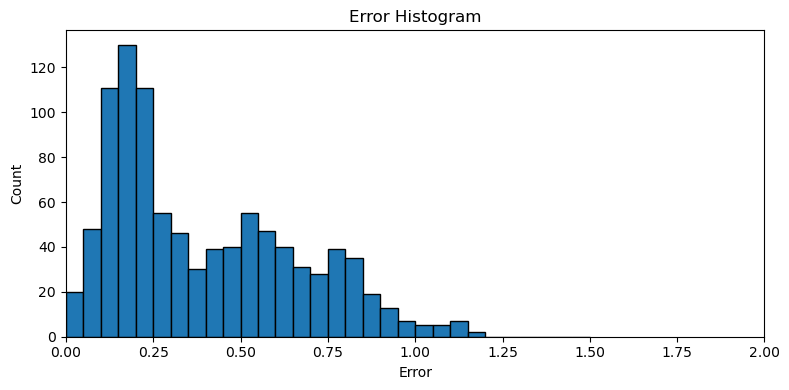

In [41]:
import numpy as np
import matplotlib.pyplot as plt

error = np.array(data['error'])
bins = np.concatenate([np.linspace(0, 1, 21), np.linspace(1, 1.5, 11)[1:]])

plt.figure(figsize=(8, 4))
plt.hist(error, bins=bins, edgecolor='black')
plt.title('Error Histogram')
plt.xlabel('Error')
plt.ylabel('Count')
plt.xlim(0, 2)
plt.tight_layout()
plt.show()

In the second plot, we filter the data between moving through the central zigzag rings and when it is not, to better demonstrate that our controller works well in this situation where maintaining the desired/established path (by checkpoints) is desired. It also demonstrates that we preferred deviation from the desired path for higher drone speeds and reactions to shorten the amount of time the drone travels for.

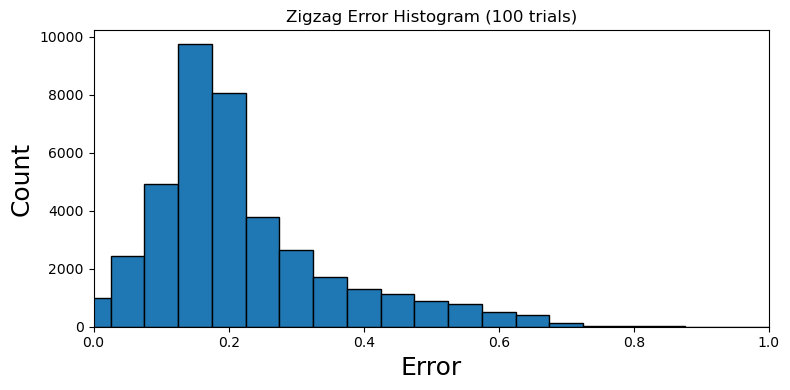

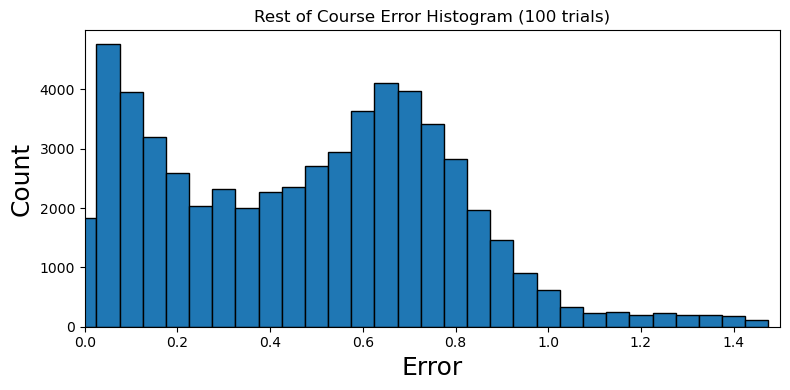

In [42]:
all_error_zigzag = []
all_error_rest = []

zigzag_intervals = [
    (6.14, 14.1),
    (26.14, 34.12)
]

for data in datas[:100]:
    error = np.array(data['error'])
    t = np.array(data['t'])
    zigzag_mask = np.zeros_like(error, dtype=bool)
    for start, end in zigzag_intervals:
        zigzag_mask |= (t >= start) & (t <= end)
    error_zigzag = error[zigzag_mask]
    error_rest = error[~zigzag_mask]
    # Exclude errors > 1.5 since they are outliers for when the simulation reaches the end and waypoint is set to an extreme value to ensure the drone drops straight down
    all_error_zigzag.append(error_zigzag[error_zigzag <= 1.5])
    all_error_rest.append(error_rest[error_rest <= 1.5])

# Concatenate all errors into single arrays
all_error_zigzag = np.concatenate(all_error_zigzag)
all_error_rest = np.concatenate(all_error_rest)

bins = np.arange(0, 1.51, 0.05)

# Zigzag error histogram
plt.figure(figsize=(8, 4))
plt.hist(all_error_zigzag, bins=bins, edgecolor='black', align='left')
plt.title('Zigzag Error Histogram (100 trials)')
plt.xlabel('Error', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Rest of course error histogram
plt.figure(figsize=(8, 4))
plt.hist(all_error_rest, bins=bins, edgecolor='black', align='left')
plt.title('Rest of Course Error Histogram (100 trials)')
plt.xlabel('Error', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xlim(0, 1.5)
plt.tight_layout()
plt.show()

In the following cell, we a histogram of error between estimated position and actual position to show how well our observer works.

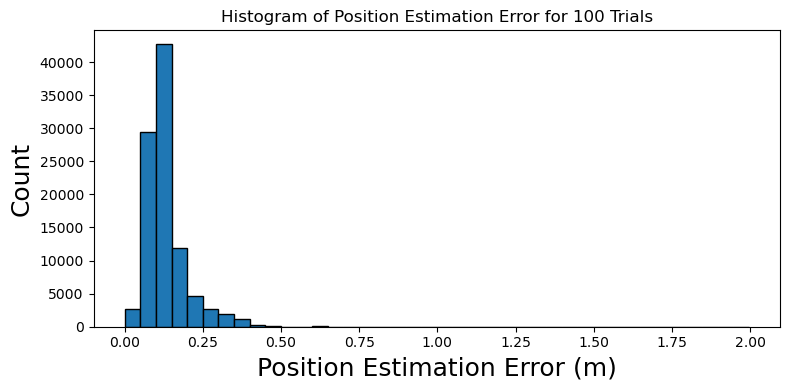

In [43]:
all_pos_errors = []
for data in datas[:100]:
    xhat = np.array(data['xhat'])
    p_actual = np.stack([data['p_x'], data['p_y'], data['p_z']], axis=1)
    p_est = xhat[:, :3]
    pos_error = np.linalg.norm(p_est - p_actual, axis=1)
    all_pos_errors.append(pos_error)

# Concatenate all errors into a single array
all_pos_errors = np.concatenate(all_pos_errors)

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(all_pos_errors, bins=40, edgecolor='black')
plt.xlabel('Position Estimation Error (m)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Histogram of Position Estimation Error for 100 Trials')
plt.tight_layout()
plt.show()

In the following cell, we plot a histogram of completion times for all successful runs.

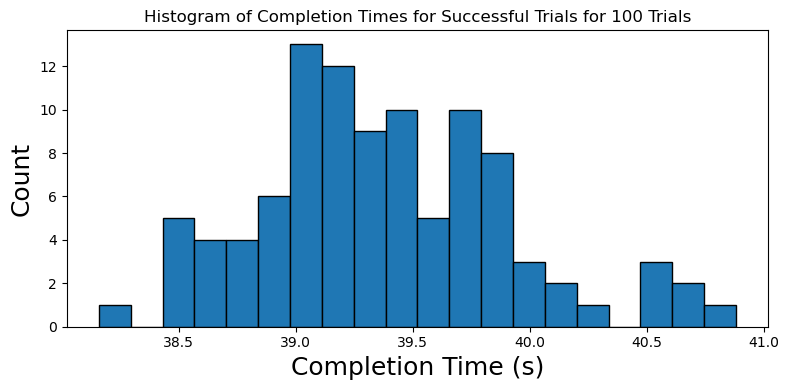

In [44]:
completion_times = []
for i, data in enumerate(datas[:100]):
    # Check if the trial finished
    if 't' in data and len(data['t']) > 0 and data['t'][-1] > 10:
        completion_times.append(data['t'][-1])

completion_times = np.array(completion_times)

plt.figure(figsize=(8, 4))
plt.hist(completion_times, bins=20, edgecolor='black')
plt.xlabel('Completion Time (s)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Histogram of Completion Times for Successful Trials for 100 Trials')
plt.tight_layout()
plt.show()

In the following cell, we plot a histogram of computation times of the run function for each time step for each trial.

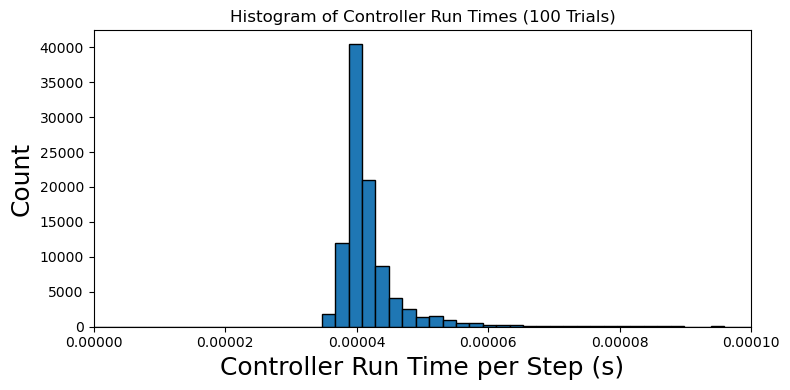

In [45]:
all_run_times = []
for data in datas[:100]:
    if 'run_time' in data:
        all_run_times.extend(data['run_time'])

all_run_times = np.array(all_run_times)

plt.figure(figsize=(8, 4))
plt.hist(all_run_times, bins=np.linspace(0, 0.0001, 50), edgecolor='black')
plt.xlabel('Controller Run Time per Step (s)', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Histogram of Controller Run Times (100 Trials)')
plt.xlim(0, 0.0001)
plt.tight_layout()
plt.show()

In the cell below, we plot the error over time for a single trial to better visualize when errors spike or increase relative to where the drone is moving through. Areas of short bursts of spike in error indicate traveling through the central zigzag rings, and anywhere else on the graph is anywhere else in the obstacle course. This graph provides context for the histogram of the error between actual position and desired position when filtered between the central zigzag rings and otherwise. 

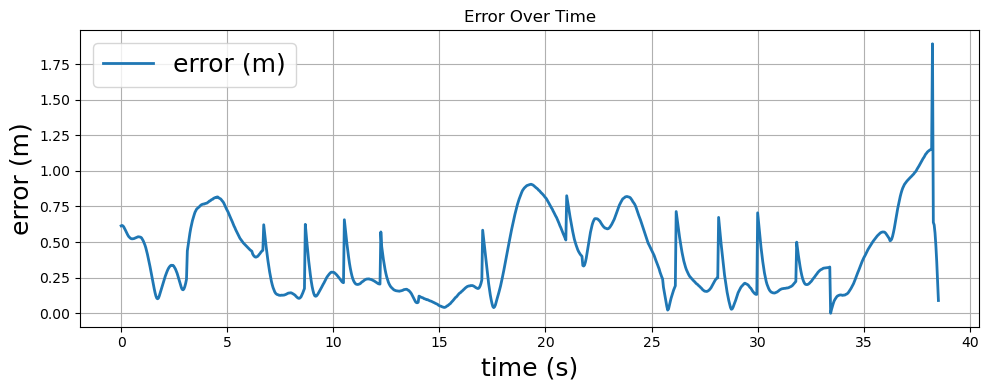

In [46]:
plt.figure(figsize=(10, 4))
plt.plot(data['t'], data['error'], label='error (m)', linewidth=2)
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('error (m)', fontsize=18)
plt.title('Error Over Time')
plt.grid()
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()